<a href="https://colab.research.google.com/github/manishkiling/Kamakhya_BERTopic/blob/main/Kamakhya_Final_BERTopic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install bertopic sentence-transformers
!pip install hdbscan
!python -m spacy download en_core_web_sm

2023-08-10 15:48:08.636970: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-10 15:48:11.248636: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 25.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [6]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import pandas as pd
import re
import spacy
import nltk
import nltk.stem
import os
nltk.download('stopwords')
from nltk.corpus import stopwords
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from hdbscan import HDBSCAN

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
import pandas as pd
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN
import nltk.stem
import nltk

# Load your data or replace this with the appropriate method to load your data
# For example, load your data from the 'Kamakhya.xlsx' file
data_path = '/content/drive/MyDrive/Kamakhya.xlsx'  # Update the path
df = pd.read_excel(data_path)
df = df.dropna(subset=["Review"])  # Drop rows with empty 'Review' values

# Pre-processing stopwords
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
stopwords = stopwords + ['one', 'go', 'get', 'rs', 'visit', 'goddess', 'kamakhya', 'temple', 'mandir', 'darshan', 'maa', 'ma', 'shakti', 'shaktipith', 'shaktipeeth', 'visit', 'visited', 'nilachal', 'nilanchal', 'hill', 'guwahati', 'view', 'city', 'assam', 'india']
english_stemmer = nltk.stem.SnowballStemmer('english')
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([english_stemmer.stem(w) for w in analyzer(doc)])

# Pre-calculate embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
corpus_embeddings = embedding_model.encode(df["Review"].tolist())

# Instantiate BERTopic model with vectorization
ngram_range = (1, 2)
nr_topics = "auto"
min_topic_size = 10
seed_topic_list = None

vectorizer_model = StemmedCountVectorizer(analyzer="word", stop_words=stopwords, ngram_range=ngram_range)

model = BERTopic(embedding_model=embedding_model,
                 vectorizer_model=vectorizer_model,
                 n_gram_range=ngram_range,
                 nr_topics=nr_topics,
                 min_topic_size=min_topic_size,
                 seed_topic_list=seed_topic_list)

# Fit BERTopic model
topics, probabilities = model.fit_transform(df["Review"].tolist())  # Pass the list of preprocessed reviews

# Get topic info
freq_df = model.get_topic_info()
print("Number of topics: {}".format(len(freq_df)))
freq_df['Percentage'] = round(freq_df['Count'] / freq_df['Count'].sum() * 100, 2)
freq_df = freq_df.iloc[:, [0, 1, 3, 2]]
freq_df.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Number of topics: 19


,Topic,Count,Representation,Name
0,-1,548,"[place, queue, take, time, hour, peopl, ticket...",-1_place_queue_take_time
1,0,167,"[hour, queue, take, vip, time, ticket, line, w...",0_hour_queue_take_vip
2,1,144,"[place, must, nice, top, line, religi, well, f...",1_place_must_nice_top
3,2,141,"[panda, help, puja, us, time, money, ticket, p...",2_panda_help_puja_us
4,3,134,"[place, good, nice, great, peopl, well, clean,...",3_place_good_nice_great


In [31]:
fig1 = model.visualize_topics()
fig1.show()

In [32]:
df_topic_freq = model.get_topic_freq()
topics_count = len(df_topic_freq) - 1
df_topic_freq

,Topic,Count
0,-1,548
1,0,167
6,1,144
3,2,141
2,3,134
9,4,116
7,5,103
4,6,94
8,7,74
15,8,34


In [33]:
model.visualize_barchart(top_n_topics=topics_count)

In [34]:
from umap import UMAP
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(corpus_embeddings)

# Visualize documents using UMAP embeddings
model.visualize_documents(df["Review"].tolist(), reduced_embeddings=reduced_embeddings)

In [35]:

# Reduce outliers using the "c-tf-idf" strategy
new_topics = model.reduce_outliers(df["Review"].tolist(), topics, strategy="c-tf-idf")

# Update the model with the latest topic assignment
model.update_topics(df["Review"].tolist(), topics=new_topics, vectorizer_model=vectorizer_model)

# Get topic info after reducing outliers
freq_df_after_reduction = model.get_topic_info()
print("Number of topics after reduction: {}".format(len(freq_df_after_reduction)))
freq_df_after_reduction['Percentage'] = round(freq_df_after_reduction['Count'] / freq_df_after_reduction['Count'].sum() * 100, 2)
freq_df_after_reduction = freq_df_after_reduction.iloc[:, [0, 1, 3, 2]]
freq_df_after_reduction.head()


Number of topics after reduction: 18


,Topic,Count,Representation,Name
0,0,294,"[queue, hour, take, ticket, time, vip, wait, 5...",0_queue_hour_take_ticket
1,1,201,"[place, must, top, nice, beauti, religi, mani,...",1_place_must_top_nice
2,2,173,"[panda, insid, puja, money, help, time, place,...",2_panda_insid_puja_money
3,3,188,"[place, good, nice, peopl, great, well, clean,...",3_place_good_nice_peopl
4,4,205,"[time, take, queue, ticket, puja, day, bus, al...",4_time_take_queue_ticket


In [36]:
model.visualize_barchart(top_n_topics=topics_count)

In [37]:
fig1 = model.visualize_topics()
fig1.show()

In [38]:
from umap import UMAP
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(corpus_embeddings)

# Visualize documents using UMAP embeddings
model.visualize_documents(df["Review"].tolist(), reduced_embeddings=reduced_embeddings)

In [20]:
import pandas as pd

In [39]:
model.save("my_topics_model")

In [40]:
BerTopic_model = BERTopic.load("my_topics_model")

In [43]:
fig4 = model.visualize_hierarchy()
fig4.show()

In [47]:
model.get_topics()

{0: [('queue', 0.025584998262574005),
  ('hour', 0.025334945135365248),
  ('take', 0.02213101752586819),
  ('ticket', 0.018621180310405657),
  ('time', 0.017946879485412983),
  ('vip', 0.016567492251735438),
  ('wait', 0.014931633713982815),
  ('500', 0.0132663330457648),
  ('crowd', 0.012282795979734895),
  ('around', 0.011994738004464269)],
 1: [('place', 0.03159489442456951),
  ('must', 0.03052349165881224),
  ('top', 0.015169517079264876),
  ('nice', 0.01387439302776357),
  ('beauti', 0.01201339194159862),
  ('religi', 0.011993686102885988),
  ('mani', 0.011814896631034142),
  ('well', 0.011456673336974088),
  ('visitor', 0.011428626519141668),
  ('time', 0.011183848462099993)],
 2: [('panda', 0.047501539160614975),
  ('insid', 0.014131248366192345),
  ('puja', 0.014005476505216248),
  ('money', 0.013992921917982182),
  ('help', 0.013906903808393668),
  ('time', 0.012377796914878435),
  ('place', 0.011827570016274326),
  ('us', 0.01115954895607474),
  ('ticket', 0.01071444898715673

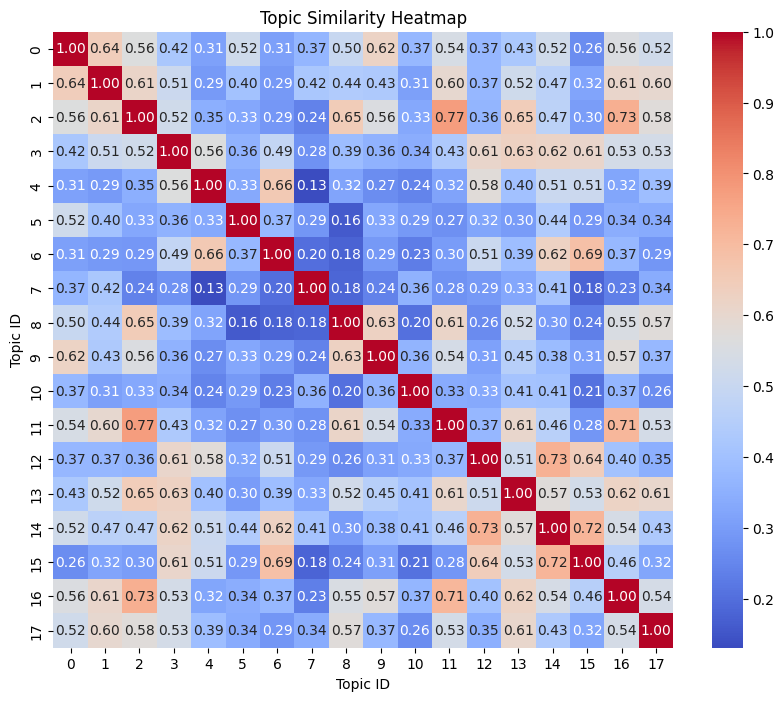

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Get all topics from the BERTopic model
all_topics = model.get_topics()

# Extract topic embeddings from corpus_embeddings based on topic IDs
topic_embeddings = [corpus_embeddings[topic_id] for topic_id in all_topics]

# Calculate topic similarity matrix
topic_similarity_matrix = cosine_similarity(topic_embeddings)

# Create a heatmap using Seaborn and Matplotlib
plt.figure(figsize=(10, 8))
sns.heatmap(topic_similarity_matrix, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Topic Similarity Heatmap')
plt.xlabel('Topic ID')
plt.ylabel('Topic ID')
plt.show()
